# Traffic Light Cycles for a Sustainable City
# Code for grid simulations
# Adamo Cerioli
# Version 22/04/2025

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import sys
import statistics as st
import math as mt
import random

# function to calculate Euclidian distance
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


# function to generate origins and destinations for n commuters within a circular grid inscribed in an N x N square grid
def generate_cars(n, N):
    
    cars = []
    center = ((N-1) // 2, (N-1) // 2)  # centre of the grid

    for _ in range(int(n)):
        while True:
            # generate random origins and destinations
            origin = [random.randint(0, N-1), random.randint(0, N-1)]
            destination = [random.randint(0, N-1), random.randint(0, N-1)]

            # calculate the Euclidean distance of both the origin and destination points from the center of the grid.
            dist_origin = euclidean_distance(center[0], center[1], origin[0], origin[1])
            dist_destination = euclidean_distance(center[0], center[1], destination[0], destination[1])

            # accept the coordinates if they both are sufficiently close to the center (inside the circle)
            if dist_origin <= N/2 and dist_destination <= N/2:
                cars.append([origin[0], origin[1], destination[0], destination[1]])
                break  # exit the while loop, as the coordinates are valid.

    return cars


# function to update the traffic light cycles
def update_cycle(matrice, p):
    return (matrice + 1) % (s)


# function to check for spillover effects
def count_congested_neighbors(C, x, y, threshold=2):

    # Get grid dimensions
    N_rows, N_cols = C.shape

    # Define the 4 direct neighbors: up, down, left, right
    neighbors = [
        (x - 1, y),  # up
        (x + 1, y),  # down
        (x, y - 1),  # left
        (x, y + 1)   # right
    ]

    c = 0  # counter for congested neighbors

    # Check each neighbor if it is inside the grid and congested
    for nx, ny in neighbors:
        if 0 <= nx < N_rows and 0 <= ny < N_cols:  # inside bounds
            if C[nx, ny] >= threshold:  # congestion test
                c += 1

    return c


# function to calculate the commuting times
def compute_commuting_times(CPF, n_max, N, I, s, time_resolution, b_c, b_p, p0, c0, generate_cars, update_cycle,
                            spillover=False, congestion=False):
    
    # commuting times are initialized
    TIME_C = []
    TIME_B = []
    
    
    # code for calculating the commuting times
    for h in CPF:    # loop over the different values of the car phase fraction

        
        # commuting times for a specific car phase fraction are initialized
        T_C = []
        T_B = []

        
        # in this section, we select specific values for the number of commuters to compute the corresponding commuting times 
        # these values serve as representative samples to estimate how commuting times vary with traffic
        # using the resulting data points, we then apply a linear best fit to extrapolate the full commuting time functions,
        # which are later scaled according to the actual maximum number of commuters in the city.
        n = np.arange(n_max/10, n_max+1, n_max/10)
        n = [int(x) for x in n]
        
        
        for j in range(len(n)):    # loop over the different values of traffic volume
            
            
            # commuting times for a specific number of commuters are initialized
            T_C_temp = []
            T_B_temp = []
            
            
            for t in range(I):    # loop over the grid iterations
                
                
                # traffic volume at all nodes is initialized
                C = np.zeros((N,N))
                B = np.zeros((N,N))


                # traffic light cycles are initialized with random values
                TL = np.random.randint(0, s, (N, N))
                
                
                # generate origins and destinations of n[j] car users and n[j] alternative transport users
                cars = generate_cars(n[j], N)
                bikes = generate_cars(n[j], N)
                
                
                # the positions at the intersections (nodes) are initialized in terms of directions: up, right, down, or left.
                cars_spin = np.random.randint(0, 4, size=n[j])
                bikes_spin = np.random.randint(0, 4, size=n[j])

                
                # position the commuters at their origin locations in the grid
                for i in range(len(cars)):
                    C[cars[i][0], cars[i][1]] += 1
                    B[bikes[i][0], bikes[i][1]] += 1
                    

                # this condition becomes false once all commuters have reached their destinations
                cond = True
                
                
                u = [0, 1]    # simple list to distinguish between origins and destinations

                
                T = 0    # inizialize the time
                
                
                # storing for commuting times calculated at the different iterations
                timesC = []
                timesB = []
                
                # allow mobility untill all commuters have reached their destinations
                while cond:
                    
                    
                    # shuffle the order of the actions of cars
                    indices = list(range(len(cars)))
                    random.shuffle(indices)
                    cars = [cars[i] for i in indices]
                    cars_spin = [cars_spin[i] for i in indices]
                    
                    
                    # shuffle the order of the actions of bikes (alternative modes)
                    indices = list(range(len(bikes)))
                    random.shuffle(indices)
                    bikes = [bikes[i] for i in indices]
                    bikes_spin = [bikes_spin[i] for i in indices]

                    
                    # the condition is set to False, but if at least one commuter has not yet reached their destination,
                    # it becomes True again.
                    cond = False
                    
                    
                    # when commuters have reached their destination they are removed from the grid
                    cars_to_remove = []
                    bikes_to_remove = []
                    
                    
                    for i in range(len(cars)):    # loop over the car commuters
                        
                        
                        # check if commuter has not yet reached the destination
                        if ([cars[i][0], cars[i][1]] != [cars[i][2], cars[i][3]]):
                            
                            cond = True    # updathe the condition 
                            
                            # this reduces the probability of movement to 1/15, effectively refining the time discretization
                            p = random.randint(0, time_resolution-1)
                            if p != 0:
                                continue

                            # check of the traffic 
                            # (since b_c is higher than b_p the probability of moving due to traffic is lower for cars)
                            
                            # Base movement probability (traffic-based)
                            prob_move = 100 * (C[cars[i][0], cars[i][1]] - 1) / C[cars[i][0], cars[i][1]]

                            # Apply spillover effects correction if enabled
                            if spillover:
                                local_cong = count_congested_neighbors(C, cars[i][0], cars[i][1])
                                prob_move *= (1 - 0.75 * local_cong / 4)
                            
                            p = random.randint(0, b_c*100*(C[cars[i][0], cars[i][1]]-1)/b_p)
                            
                            # Apply non-linear congestion effects correction if enabled
                            if congestion:

                                p_congestion = 1 - mt.exp(-C_1 * (C[cars[i][0], cars[i][1]] - 1)**C_2)
                        
                                if random.random() < p_congestion:
                            
                                    prob_move *= 1/(C[cars[i][0], cars[i][1]])**C_2
                            
                            if p <= prob_move:
                                
                                # check if the possible shortest paths include an horizontal movement and/or a vertical movement
                                pos = []
                                for us in u:
                                    if cars[i][0+us] != cars[i][2+us]:
                                        pos.append(us)
                                
                                # check if cars can move horizontally* (first phase of the traffic light cycle)
                                if TL[cars[i][0], cars[i][1]] <= (h-1)/2:
                                    
                                    # "normal" horizontal movement  
                                    if u[0] in pos:
                                        
                                        # remove car from the grid
                                        C[cars[i][0], cars[i][1]] -= 1
                                        
                                        # check movements and update position
                                        if (cars_spin[i] != 1) & (cars[i][0+u[0]] > cars[i][2+u[0]]):
                                            cars[i][0+u[0]] -= 1
                                            cars_spin[i] = 2
                                        elif (cars_spin[i] != 3) & (cars[i][0+u[0]] < cars[i][2+u[0]]):
                                            cars[i][0+u[0]] += 1
                                            cars_spin[i] = 0
                                        
                                        # check if the car has reached its destination
                                        if [cars[i][0], cars[i][1]] == [cars[i][2], cars[i][3]]:
                                            timesC.append(T)    # save the commuting time
                                            cars_to_remove.append(i)   # store the car for removing it from the simulations
                                        else:
                                            C[cars[i][0], cars[i][1]] += 1    # place back the car in the grid (new position)
                                    
                                    # check for tha "alternative" movements allowed during the phase
                                    elif (cars_spin[i] == 0) & (cars[i][0+u[1]] > cars[i][2+u[1]]):
                                        C[cars[i][0], cars[i][1]] -= 1
                                        cars[i][0+u[1]] -= 1
                                        
                                        if [cars[i][0], cars[i][1]] == [cars[i][2], cars[i][3]]:
                                            timesC.append(T)
                                            cars_to_remove.append(i)
                                        else:
                                            C[cars[i][0], cars[i][1]] += 1
                                            cars_spin[i] = 1

                                    elif (cars_spin[i] == 2) & (cars[i][0+u[1]] < cars[i][2+u[1]]):
                                        C[cars[i][0], cars[i][1]] -= 1
                                        cars[i][0+u[1]] += 1
                                        
                                        if [cars[i][0], cars[i][1]] == [cars[i][2], cars[i][3]]:
                                            timesC.append(T)
                                            cars_to_remove.append(i)
                                        else:
                                            C[cars[i][0], cars[i][1]] += 1
                                            cars_spin[i] = 3
                                    
                                    
                                # check if cars can move vertically* (second phase of the traffic light cycle)
                                elif TL[cars[i][0], cars[i][1]] <= h:
                                    
                                    # "normal" vertical movement  
                                    if u[1] in pos:
                                        
                                        # remove car from the grid
                                        C[cars[i][0], cars[i][1]] -= 1
                                        
                                        # check movements and update position
                                        if (cars_spin[i] != 0) & (cars[i][0+u[1]] > cars[i][2+u[1]]):
                                            cars[i][0+u[1]] -= 1
                                            cars_spin[i] = 1
                                        elif (cars_spin[i] != 2) & (cars[i][0+u[1]] < cars[i][2+u[1]]):
                                            cars[i][0+u[1]] += 1
                                            cars_spin[i] = 3
                                        
                                        # check if the car has reached its destination
                                        if [cars[i][0], cars[i][1]] == [cars[i][2], cars[i][3]]:
                                            timesC.append(T)    # save the commuting time
                                            cars_to_remove.append(i)    # store the car for removing it from the simulations
                                        else:
                                            C[cars[i][0], cars[i][1]] += 1    # place back the car in the grid (new position)
                                    
                                    # check for tha "alternative" movements allowed during the phase
                                    elif (cars_spin[i] == 1) & (cars[i][0+u[0]] > cars[i][2+u[0]]):
                                        
                                        C[cars[i][0], cars[i][1]] -= 1
                                        cars[i][0+u[0]] -= 1
                                        
                                        if [cars[i][0], cars[i][1]] == [cars[i][2], cars[i][3]]:
                                            timesC.append(T)
                                            cars_to_remove.append(i)
                                        else:
                                            C[cars[i][0], cars[i][1]] += 1
                                            cars_spin[i] = 2
                                            
                                    elif (cars_spin[i] == 3) & (cars[i][0+u[0]] < cars[i][2+u[0]]):
                                        C[cars[i][0], cars[i][1]] -= 1
                                        cars[i][0+u[0]] += 1
                                        
                                        if [cars[i][0], cars[i][1]] == [cars[i][2], cars[i][3]]:
                                            timesC.append(T)
                                            cars_to_remove.append(i)
                                        else:
                                            C[cars[i][0], cars[i][1]] += 1
                                            cars_spin[i] = 0
                                    
                                
                    # repeat the algorithm for bikes
                    # only the fundamental differences have a comment
                    for i in range(len(bikes)):    # loop over the bike (or alternative transport) commuters 
                        
                        
                        if ([bikes[i][0], bikes[i][1]] != [bikes[i][2], bikes[i][3]]):
                            cond = True
                            
                            p = random.randint(0, time_resolution-1)
                            if p != 0:
                                continue
                            
                            # Base movement probability (traffic-based)
                            prob_move = 100

                            # Apply spillover effects correction if enabled
                            if spillover:
                                local_cong = count_congested_neighbors(B, bikes[i][0], bikes[i][1])
                                prob_move *= (1 - 0.75 * local_cong / 4)
                            
                            # Apply non-linear congestion effects correction if enabled
                            if congestion:

                                p_congestion = 1 - mt.exp(-C_1 * (B[bikes[i][0], bikes[i][1]] - 1)**C_2)
                        
                                if random.random() < p_congestion:
                            
                                    prob_move *= 1/(B[bikes[i][0], bikes[i][1]])**C_2
                            
                            # check for movements not related to traffic
                            # (since p0 is higher than c0, the probability of moving regardless of traffic is lower for bikes)
                            p = random.randint(0, int(p0*100/c0))
                            if  p <= prob_move:
                                
                                
                                p = random.randint(0, 100*(B[bikes[i][0], bikes[i][1]]-1))
                                
                                if p <= 100*(B[bikes[i][0], bikes[i][1]]-1)/B[bikes[i][0], bikes[i][1]]:
                                    
                                    pos = []
                                    for us in u:
                                        if bikes[i][0+us] != bikes[i][2+us]:
                                            pos.append(us)
                                    
                                    
                                    if (TL[bikes[i][0], bikes[i][1]] > h) & (TL[bikes[i][0], bikes[i][1]] <= (h+s-1)/2):
                                        
                                        if u[0] in pos:
                                            
                                            B[bikes[i][0], bikes[i][1]] -= 1
                                            
                                            if (bikes_spin[i] != 1) & (bikes[i][0+u[0]] > bikes[i][2+u[0]]):
                                                bikes[i][0+u[0]] -= 1
                                                bikes_spin[i] = 2
                                            elif (bikes_spin[i] != 3) & (bikes[i][0+u[0]] < bikes[i][2+u[0]]):
                                                bikes[i][0+u[0]] += 1
                                                bikes_spin[i] = 0
                                                
                                            if [bikes[i][0], bikes[i][1]] == [bikes[i][2], bikes[i][3]]:
                                                timesB.append(T)
                                                bikes_to_remove.append(i)
                                            else:
                                                B[bikes[i][0], bikes[i][1]] += 1
                                        

                                        elif (bikes_spin[i] == 0) & (bikes[i][0+u[1]] > bikes[i][2+u[1]]):
                                            B[bikes[i][0], bikes[i][1]] -= 1
                                            bikes[i][0+u[1]] -= 1
                                            
                                            if [bikes[i][0], bikes[i][1]] == [bikes[i][2], bikes[i][3]]:
                                                timesB.append(T)
                                                bikes_to_remove.append(i)
                                            else:
                                                B[bikes[i][0], bikes[i][1]] += 1
                                                bikes_spin[i] = 1

                                        elif (bikes_spin[i] == 2) & (bikes[i][0+u[1]] < bikes[i][2+u[1]]):
                                            B[bikes[i][0], bikes[i][1]] -= 1
                                            bikes[i][0+u[1]] += 1
                                            
                                            if [bikes[i][0], bikes[i][1]] == [bikes[i][2], bikes[i][3]]:
                                                timesB.append(T)
                                                bikes_to_remove.append(i)
                                            else:
                                                B[bikes[i][0], bikes[i][1]] += 1
                                                bikes_spin[i] = 3
                                    
                                    elif TL[bikes[i][0], bikes[i][1]] > (h+s-1)/2:
                                        
                                        if u[1] in pos:
                                            
                                            B[bikes[i][0], bikes[i][1]] -= 1
                                            
                                            if (bikes_spin[i] != 0) & (bikes[i][0+u[1]] > bikes[i][2+u[1]]):
                                                bikes[i][0+u[1]] -= 1
                                                bikes_spin[i] = 1
                                            elif (bikes_spin[i] != 2) & (bikes[i][0+u[1]] < bikes[i][2+u[1]]):
                                                bikes[i][0+u[1]] += 1
                                                bikes_spin[i] = 3
                                                
                                            if [bikes[i][0], bikes[i][1]] == [bikes[i][2], bikes[i][3]]:
                                                timesB.append(T)
                                                bikes_to_remove.append(i)
                                            else:
                                                B[bikes[i][0], bikes[i][1]] += 1
                                        

                                        elif (bikes_spin[i] == 1) & (bikes[i][0+u[0]] > bikes[i][2+u[0]]):
                                            B[bikes[i][0], bikes[i][1]] -= 1
                                            bikes[i][0+u[0]] -= 1
                                            
                                            if [bikes[i][0], bikes[i][1]] == [bikes[i][2], bikes[i][3]]:
                                                timesB.append(T)
                                                bikes_to_remove.append(i)
                                            else:
                                                B[bikes[i][0], bikes[i][1]] += 1
                                                bikes_spin[i] = 2

                                        elif (bikes_spin[i] == 3) & (bikes[i][0+u[0]] < bikes[i][2+u[0]]):
                                            B[bikes[i][0], bikes[i][1]] -= 1
                                            bikes[i][0+u[0]] += 1
                                            
                                            if [bikes[i][0], bikes[i][1]] == [bikes[i][2], bikes[i][3]]:
                                                timesB.append(T)
                                                bikes_to_remove.append(i)
                                            else:
                                                B[bikes[i][0], bikes[i][1]] += 1
                                                bikes_spin[i] = 0
                    
                    
                    # remove cars and bikes that have already reached their destination
                    cars = [cars[i] for i in range(len(cars)) if i not in cars_to_remove]
                    bikes = [bikes[i] for i in range(len(bikes)) if i not in bikes_to_remove] 
                    cars_spin = [cars_spin[i] for i in range(len(cars_spin)) if i not in cars_to_remove]
                    bikes_spin = [bikes_spin[i] for i in range(len(bikes_spin)) if i not in bikes_to_remove]             
                                
                    # update the time  
                    T += 1
                    
                    # move forward the traffic light cycles
                    TL = update_cycle(TL, s)
                
                # save the averages of the commuting times
                # the try...except is used because it is possible that all commuters have coinciding origins and destinations
                try:
                    T_C_temp.append(st.mean(timesC))
                except:
                    T_C_temp.append(0)
                    
                try:
                    T_B_temp.append(st.mean(timesB))
                except:
                    T_B_temp.append(0)

            
            # save the averages of the mean commuting times (each one associated to an iteration)
            T_C.append(st.mean(T_C_temp))
            T_B.append(st.mean(T_B_temp))
     
        
        if not congestion:
        
            # list of fractions of commuters
            n = [x/n_max for x in n]
        
            n_B = n
        
            # best linear fit for cars
            m1, q1 = np.polyfit(n, T_C, 1)

            # best linear fit for bikes
            m2, q2 = np.polyfit(n_B, T_B, 1)
        
            # values for calculating the commuting time
            n_extra = np.arange(0, 1.01, 0.1)

            # corresponding values on the line: y = m1 * x + q1
            T_C = m1 * n_extra + q1
        
            # corresponding values on the line: y = m2 * x + q2
            T_B = m2 * n_extra + q2
        
        # save the commuting times
        TIME_C.append(T_C)
        TIME_B.append(T_B)
    
    return TIME_C, TIME_B


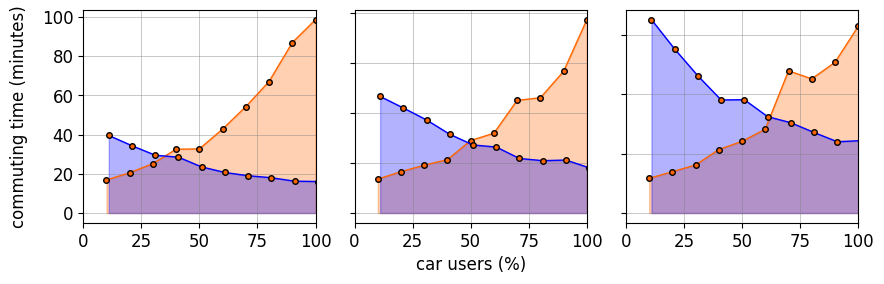

In [3]:
# car parameters 
c0 = 8    # free-flow commuting time
b_c = 14    # traffic dependency


# alternative transport parameters
p0 = 13    # free-flow commuting time
b_p = 5    # traffic dependency


# grid size: total number of nodes along the diameter of the circular grid
N = 10 


# number of iterations
I = 50


# Temporal resolution: higher values mean finer time discretization (i.e., smaller time steps)
time_resolution = 15


# total number of commuters
n_max = 50


# duration of the traffic light cycle
s = 60


# congestion parameters
C_1 = 0.2
C_2 = 1.5


# list of car phase fractions (allocation of green time to cars)
CPF = [23, 29, 35]    # (23+1)/60 = 40% , (29+1)/60 = 50% , (35+1)/60 = 60%


TIME_C, TIME_B = compute_commuting_times(CPF, n_max, N, I, s, time_resolution, b_c, b_p, p0, c0, generate_cars, update_cycle,
                                        spillover=True, congestion=True)


# original time duration (minutes) of a time step
minutes = 0.5


# convert the commuting times in minutes according the original time duration of a time step and the time resolution
for i in range(len(TIME_C)):
    
    TIME_C[i] = [x*minutes/time_resolution for x in TIME_C[i]]
    TIME_B[i] = [x*minutes/time_resolution for x in TIME_B[i]]


# create a plot
plt.rcParams.update({'font.size': 12})
fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
ax1[0].grid(axis="x", color="gray", linestyle="-", linewidth = 0.5, alpha = 0.6 )
ax1[0].grid(axis="y", color="gray", linestyle="-", linewidth = 0.5, alpha = 0.6 )
ax1[1].grid(axis="x", color="gray", linestyle="-", linewidth = 0.5, alpha = 0.6 )
ax1[1].grid(axis="y", color="gray", linestyle="-", linewidth = 0.5, alpha = 0.6 )
ax1[2].grid(axis="x", color="gray", linestyle="-", linewidth = 0.5, alpha = 0.6 )
ax1[2].grid(axis="y", color="gray", linestyle="-", linewidth = 0.5, alpha = 0.6 )

# fraction of commuter for cars
x = np.arange(10,101,10)

# fraction of commuter for bikes (it goes in the opposite direction)
x_B = np.arange(101,10,-10)



for i in range(len(CPF)):
    
    ax1[i].plot(
    x, TIME_C[i],
    color="#FF6600",
    linewidth=1,
    linestyle="-",
    marker="o",
    markersize=4,
    markerfacecolor="#FF6600",
    markeredgecolor="black")
    
    ax1[i].fill_between(x, TIME_C[i], color="#FF6600", alpha=0.3)
    
    ax1[i].plot(
    x_B, TIME_B[i],
    color="blue",
    linewidth=1,
    linestyle="-",
    marker="o",
    markersize=4,
    markerfacecolor="#FF6600",
    markeredgecolor="black")
    
    ax1[i].fill_between(x_B, TIME_B[i], color="blue", alpha=0.3)

    ax1[i].set_xlim(0, 100)


ax1[1].set_xlabel("car users (%)")
ax1[0].set_ylabel("commuting time (minutes)", labelpad=10)


ax1[1].set_yticklabels([])
ax1[2].set_yticklabels([])
plt.tight_layout()